In [ ]:
!pip install -U scikit-learn

In [ ]:
pip install -U imbalanced-learn scikit-learn

Fitting 2 folds for each of 10 candidates, totalling 20 fits


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.7107
Precision: 0.6735
Recall: 0.7107
F1-score: 0.6571


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classification Report:
                   precision    recall  f1-score   support

     Fatal Crash       0.00      0.00      0.00       132
     Minor Crash       0.61      0.31      0.41      3765
Non-Injury Crash       0.73      0.96      0.83      8822
   Serious Crash       0.49      0.07      0.13       981

        accuracy                           0.71     13700
       macro avg       0.46      0.34      0.34     13700
    weighted avg       0.67      0.71      0.66     13700



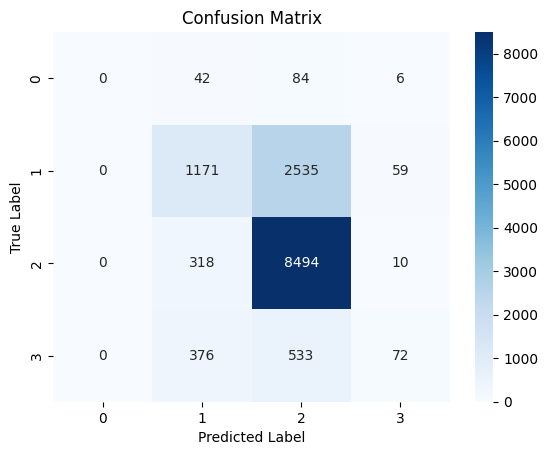

Cross-validation scores: [0.78554745 0.66510949 0.67240876 0.71445255 0.67632674]
Mean cross-validation score: 0.7027689974706449


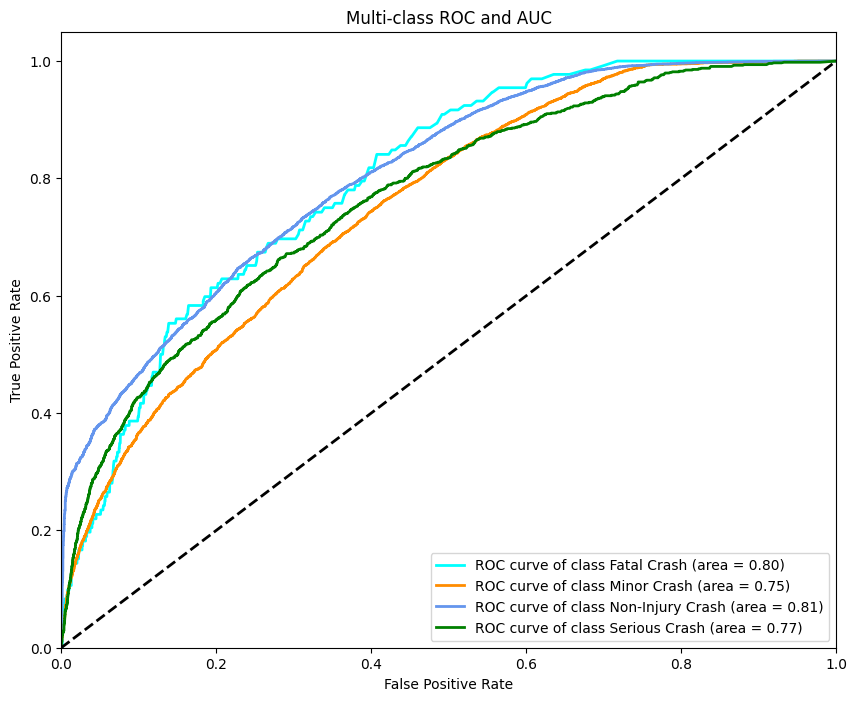

In [ ]:
import csv
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelBinarizer
from itertools import cycle




# Convert categorical variables to numerical using one-hot encoding
X = pd.get_dummies(data.drop('Crash severity', axis=1))
y = data['Crash severity']


# Split data into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split training data to separate out a tuning set (10% of the original dataset)
X_tune, X_not_tune, y_tune, y_not_tune = train_test_split(X_train, y_train, test_size=0.90, random_state=42)  # Adjusted to keep 10% for tuning

# Apply SMOTE to the tuning data
smote = SMOTE(random_state=42)
X_tune_smote, y_tune_smote = smote.fit_resample(X_tune, y_tune)

# Define the hyperparameter grid to search
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [10, 20, 30, 40, 50, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the base model
rf = RandomForestClassifier(random_state=42)

# Perform Random Search with reduced complexity
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=10, cv=2, verbose=2, random_state=42, n_jobs=-1)
rf_random.fit(X_tune_smote, y_tune_smote)

# Use the best estimator from the random search to fit the entire training set (excluding tuning set)
best_rf = rf_random.best_estimator_
best_rf.fit(X_train, y_train)

# Predict and evaluate using the test set
y_pred = best_rf.predict(X_test)

# Calculate and print metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Accuracy: {accuracy:.4f}\nPrecision: {precision:.4f}\nRecall: {recall:.4f}\nF1-score: {f1:.4f}")

# Classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
confusion = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


# Correcting the cross-validation section
cv_scores = cross_val_score(best_rf, X, y, cv=5, scoring='accuracy', n_jobs=-1)  # Use 'best_rf' and 'X'
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())

# Assuming 'y' needs to be binarized for multi-class ROC AUC calculation
# Initialize and fit LabelBinarizer if not already done
lb = LabelBinarizer()
y_bin = lb.fit_transform(y)  # Ensure 'y' is the original target variable
y_test_bin = lb.transform(y_test)  # Transform the test labels

# Predict probabilities for ROC curve calculation
y_pred_proba = best_rf.predict_proba(X_test)

# Compute ROC curve and ROC AUC for each class
n_classes = y_bin.shape[1]
fpr, tpr, roc_auc = dict(), dict(), dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(lb.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC and AUC')
plt.legend(loc="lower right")
plt.show()


Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 16}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.6951
Precision: 0.6662
Recall: 0.6951
F1-score: 0.6237


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classification Report:
                   precision    recall  f1-score   support

     Fatal Crash       0.00      0.00      0.00       132
     Minor Crash       0.66      0.20      0.30      3765
Non-Injury Crash       0.70      0.98      0.82      8822
   Serious Crash       0.45      0.11      0.17       981

        accuracy                           0.70     13700
       macro avg       0.45      0.32      0.32     13700
    weighted avg       0.67      0.70      0.62     13700



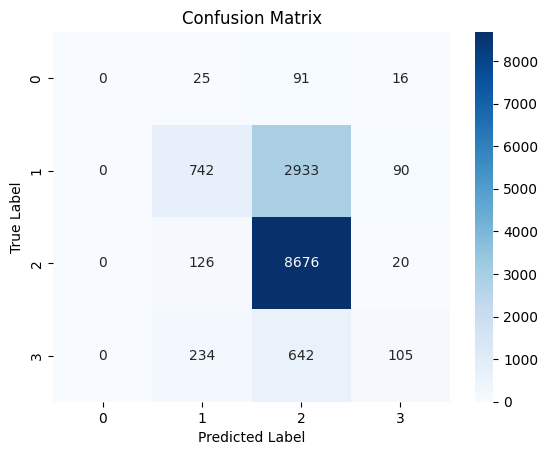

Cross-validation scores: [0.75058394 0.65824818 0.66087591 0.68226277 0.65683627]
Mean cross-validation score: 0.6817614136681083


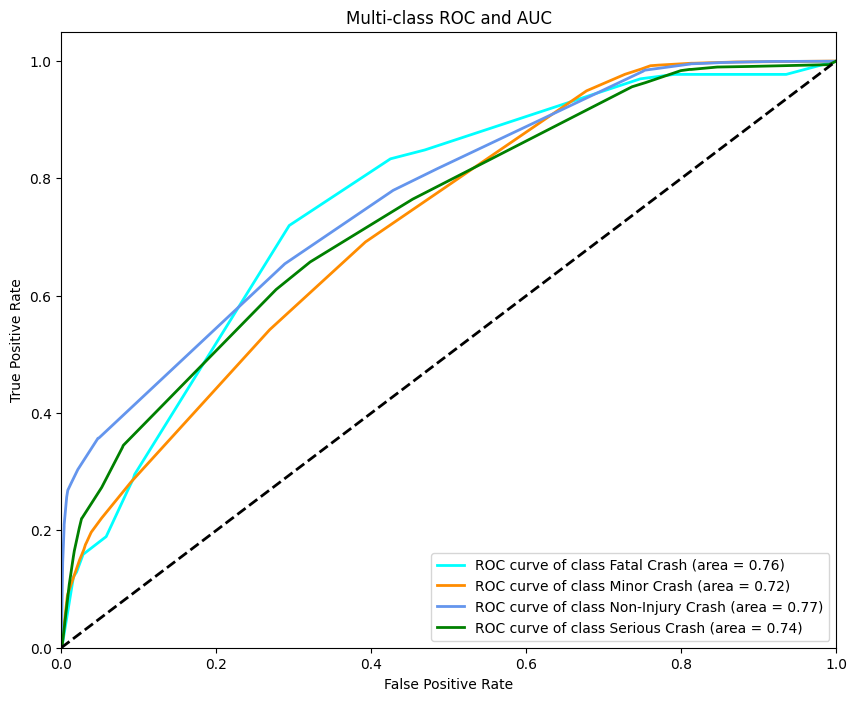

In [ ]:
import csv
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from scipy.stats import randint
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelBinarizer
from itertools import cycle
from scipy import interp
import numpy as np

# Assuming Google Drive is mounted and CSV file path is defined

# Initialize an empty list to store the rows
rows = []

# Open the file and read it with the csv.reader
try:
    with open(csv_file_path, 'r', encoding='utf-8') as file:
        reader = csv.reader(file)
        for row in reader:
            rows.append(row)
except Exception as e:
    print(f"An error occurred while reading the CSV file: {e}")

# Convert the list of rows to a DataFrame if rows were read successfully
if rows:
    data = pd.DataFrame(rows[1:], columns=rows[0])
    # Selecting relevant features for the model
    features = ['Simple / complex crash', 'Number of vehicles involved', 'Crash year',
                'Day of the week', 'Month of year', 'Is weekend', 'TLA (Territorial local authority)',
                'Regional council', 'Road category', 'Deprivation mesh block deprivation index',
                'Intersection / midblock', 'Urban or open speed zone', 'Posted speed limit',
                'Junction type', 'Road curvature', 'Road feature', 'Gradient', 'Surface type',
                'Road type', 'Street lights', 'Number of lanes', 'Traffic control present',
                'Primary surface condition', 'Road markings', 'Natural Light', 'Primary weather',
                'Vehicle 1 type', 'Ethnicity', 'Gender', 'Road user type', 'Crash severity']

    data = data[features]

    # Separating the target variable before applying one-hot encoding
    target_variable = 'Crash severity'
    X = data.drop(target_variable, axis=1)
    y = data[target_variable]

    # Convert categorical variables to numerical using one-hot encoding
    X_encoded = pd.get_dummies(X, columns=X.select_dtypes(include=['object']).columns)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Use only 1% of the training data for hyperparameter tuning
X_train_sample, _, y_train_sample, _ = train_test_split(X_train, y_train, test_size=0.99, random_state=42)

# Define a hyperparameter distribution instead of a fixed grid
param_dist = {
    'max_depth': [None] + list(range(5, 21)),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'criterion': ['gini', 'entropy']
}

# Initialize the Decision Tree Classifier
dt_clf = DecisionTreeClassifier(random_state=42)

# Perform hyperparameter tuning using RandomizedSearchCV on the 1% sample
random_search = RandomizedSearchCV(dt_clf, param_distributions=param_dist, n_iter=100, cv=3, scoring='accuracy', n_jobs=-1, random_state=42)
random_search.fit(X_train_sample, y_train_sample)

# Get the best hyperparameters
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

# Initialize the Decision Tree Classifier with best hyperparameters
dt_clf_best = DecisionTreeClassifier(random_state=42, **best_params)

# Train the model on the full training set
dt_clf_best.fit(X_train, y_train)

# Make predictions on the test set
y_pred = dt_clf_best.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Display the Confusion Matrix
confusion = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Cross-validation on the full dataset with the best parameters
cv_scores = cross_val_score(dt_clf_best, X_encoded, y, cv=5, scoring='accuracy', n_jobs=-1)
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())

# Additional steps for ROC AUC plot are needed here, which depend on the DecisionTreeClassifier's ability to predict probabilities.
# Assuming 'y' is binarized for multi-class ROC AUC calculation:
# Binarize the output
# Binarize y_test for ROC calculations
y_test_bin = lb.transform(y_test)

# Predict probabilities for ROC curve calculation
y_pred_proba = dt_clf_best.predict_proba(X_test)

# Compute ROC curve and ROC AUC for each class
n_classes = y_bin.shape[1]
fpr, tpr, roc_auc = dict(), dict(), dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(lb.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC and AUC')
plt.legend(loc="lower right")
plt.show()


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8087207543508868, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8087207543508868
[LightGBM] [Warning] bagging_fraction is set=0.9144008398418366, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9144008398418366
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8087207543508868, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8087207543508868
[LightGBM] [Warning] bagging_fraction is set=0.9144008398418366, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9144008398418366
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007402 seconds

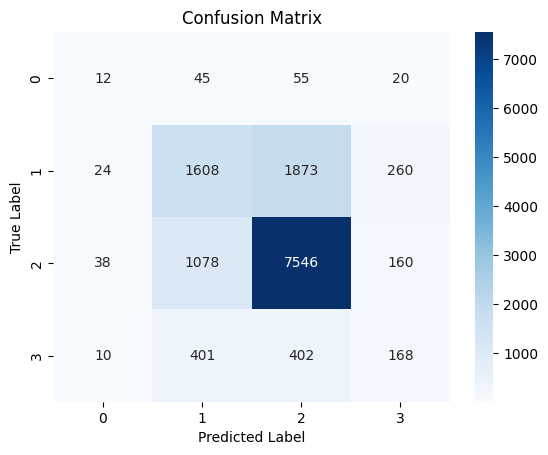

Cross-validation scores: [0.68579953 0.77051218 0.82791078 0.83063972 0.83220261]
Mean cross-validation score: 0.7894129632899473
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8087207543508868, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8087207543508868
[LightGBM] [Warning] bagging_fraction is set=0.9144008398418366, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9144008398418366


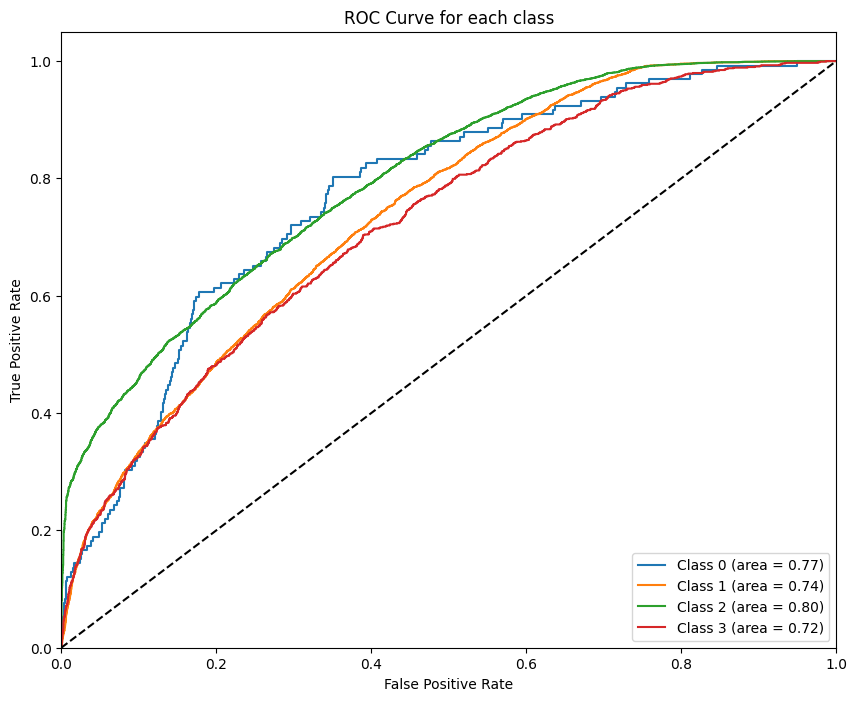

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from scipy.stats import randint, uniform
import numpy as np
import lightgbm as lgb
from itertools import cycle

# Assuming Google Drive is mounted and the CSV file path is defined
csv_file_path = '/content/drive/My Drive/Cleaned_data.csv'

# Read the CSV file directly into a DataFrame
data = pd.read_csv(csv_file_path)

# Selecting relevant features for the model
features = ['Number of vehicles involved', 'Crash year',
            'Day of the week', 'Month of year', 'Is weekend', 'TLA (Territorial local authority)',

            'Regional council', 'Road category', 'Intersection / midblock', 'Urban or open speed zone',
            'Posted speed limit', 'Junction type', 'Road curvature', 'Road feature', 'Gradient',
            'Surface type', 'Road type', 'Street lights', 'Number of lanes', 'Traffic control present',
            'Primary surface condition', 'Road markings', 'Natural Light', 'Primary weather',
            'Vehicle 1 type', 'Ethnicity', 'Gender', 'Road user type', 'Crash severity']
data = data[features]

# Handling missing values (Example approach, adjust according to your data)
data.fillna(method='ffill', inplace=True)

# Encoding categorical variables
label_encoder = LabelEncoder()
for column in data.select_dtypes(include=['object']).columns:
    data[column] = label_encoder.fit_transform(data[column])

# Separating the target variable and features
X = data.drop('Crash severity', axis=1)
y = data['Crash severity']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to balance the training data
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Define a parameter distribution for RandomizedSearchCV
param_dist = {
    'learning_rate': uniform(0.01, 0.3),
    'num_leaves': randint(20, 50),
    'feature_fraction': uniform(0.8, 0.2),
    'bagging_fraction': uniform(0.8, 0.2),
    'bagging_freq': randint(1, 10)
}

# Use a subset of data for tuning (1% of the training data)
X_sample, _, y_sample, _ = train_test_split(X_train_smote, y_train_smote, test_size=0.80, random_state=42)

# Initialize the LightGBM model
gbm = lgb.LGBMClassifier(objective='multiclass', num_class=len(np.unique(y_train_smote)), random_state=42)

# Perform hyperparameter tuning using RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=gbm, param_distributions=param_dist, n_iter=100, cv=3, scoring='accuracy', n_jobs=-1, random_state=42)
random_search.fit(X_sample, y_sample)

# Best parameters found
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

# Train the model with the best parameters on the full training data
best_gbm = lgb.LGBMClassifier(**best_params, objective='multiclass', num_class=len(np.unique(y_train_smote)), random_state=42)
best_gbm.fit(X_train_smote, y_train_smote)

# Predict on the test data
y_pred = best_gbm.predict(X_test)

# Calculate and print metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

# Print the classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Display the confusion matrix
confusion = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Cross-validation scores
cv_scores = cross_val_score(best_gbm, X_train_smote, y_train_smote, cv=5, scoring='accuracy', n_jobs=-1)
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())

# Binarize the labels for the ROC curve
lb = LabelBinarizer()
y_test_binarized = lb.fit_transform(y_test)
y_pred_proba = best_gbm.predict_proba(X_test)

# Compute ROC curve and AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(lb.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(len(lb.classes_)):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for each class')
plt.legend(loc="lower right")
plt.show()
